#  Intro to the ATLAS/ICESat-2 Monthly Gridded Sea Ice Thickness Dataset 
This gridded dataset provides several useful sea ice variables, including thickness, freeboard, and snow depth. Here, we'll show you how to easily download the data from our public google storage bucket and how to generate some simple plots for a few variables of interest.

In [1]:
import xarray as xr # For working with gridded climate data 
from utils.read_data_utils import read_is2_data # Helper function for reading the data from the bucket

# Plotting dependencies
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh # Helps avoid some weird issues with the polar projection 
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150 # Sets figure size in the notebook

# Remove warnings to improve display
import warnings 
warnings.filterwarnings('ignore') 

# Read in ICESat-2 netcdf4 files using xarray
Here, we'll read in the data from the jupyter book using a function `read_is2_data` , defined in the `read_data_utils` module. You can also download this same data from the NSIDC. See the `data_wrangling` notebook for more information on this dataset.<br><br> The function reads in the data as an xarray Dataset object. [xarray](http://xarray.pydata.org/en/stable/) is a python package built for working with gridded data and is particularly useful for climate data in the form of netcdf4 files 

In [2]:
print(read_is2_data.__doc__) # Print docstring

 Read in ATLAS/ICESat-2 Monthly Gridded Sea Ice Freeboard dataset. 
    If the file does not already exist on the user's local drive, it is downloaded from the books google storage bucket (https://console.cloud.google.com/storage/browser/is2-pso-seaice)
    The netcdf files for each month are then read in as an xr.Dataset object
    
    Args: 
        data_dir (str, optional): name of data directory containing ICESat-2 data (default to "IS2SITMOGR4/v002", the name of the directory in the bucket)
        bucket_name (str, optional): name of google storage bucket (default to "sea-ice-thickness-data")
    Returns: 
        is2_ds (xr.Dataset): data 
    
    


In [3]:
is2_ds = read_is2_data() # Read in data
print(is2_ds) # Display the data 

Created directory IS2SITMOGR4/v002


Copying gs://sea-ice-thickness-data/IS2SITMOGR4/v002/IS2SITMOGR4_01_201811_005_002.nc...
\ [1/1 files][  9.4 MiB/  9.4 MiB] 100% Done                                    
Operation completed over 1 objects/9.4 MiB.                                      
Copying gs://sea-ice-thickness-data/IS2SITMOGR4/v002/IS2SITMOGR4_01_201812_005_002.nc...
- [1/1 files][  9.4 MiB/  9.4 MiB] 100% Done                                    
Operation completed over 1 objects/9.4 MiB.                                      
Copying gs://sea-ice-thickness-data/IS2SITMOGR4/v002/IS2SITMOGR4_01_201901_005_002.nc...
\ [1/1 files][  9.4 MiB/  9.4 MiB] 100% Done                                    
Operation completed over 1 objects/9.4 MiB.                                      
Copying gs://sea-ice-thickness-data/IS2SITMOGR4/v002/IS2SITMOGR4_01_201902_005_002.nc...
| [1/1 files][  9.4 MiB/  9.4 MiB] 100% Done                                    
Operation completed over 1 objects/9.4 MiB.                               

<xarray.Dataset>
Dimensions:            (time: 22, y: 448, x: 304)
Coordinates:
  * time               (time) datetime64[ns] 2018-11-01 ... 2021-04-01
    longitude          (y, x) float32 168.3 168.1 168.0 ... -10.36 -10.18 -9.999
    latitude           (y, x) float32 31.1 31.2 31.3 31.39 ... 34.68 34.58 34.47
    xgrid              (y, x) float32 -3.838e+06 -3.812e+06 ... 3.738e+06
    ygrid              (y, x) float32 5.838e+06 5.838e+06 ... -5.338e+06
Dimensions without coordinates: y, x
Data variables: (12/15)
    projection         (time) float64 -2.147e+09 -2.147e+09 ... -2.147e+09
    ice_thickness      (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    ice_thickness_unc  (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    num_segments       (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    mean_day_of_month  (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    snow_depth         (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    

# Overlay sea ice thickness on a map of the Arctic 
xarray allows us to generate a quick and simple map of the data in just a few lines of code. Below, we'll plot sea ice thickness for a single month. 

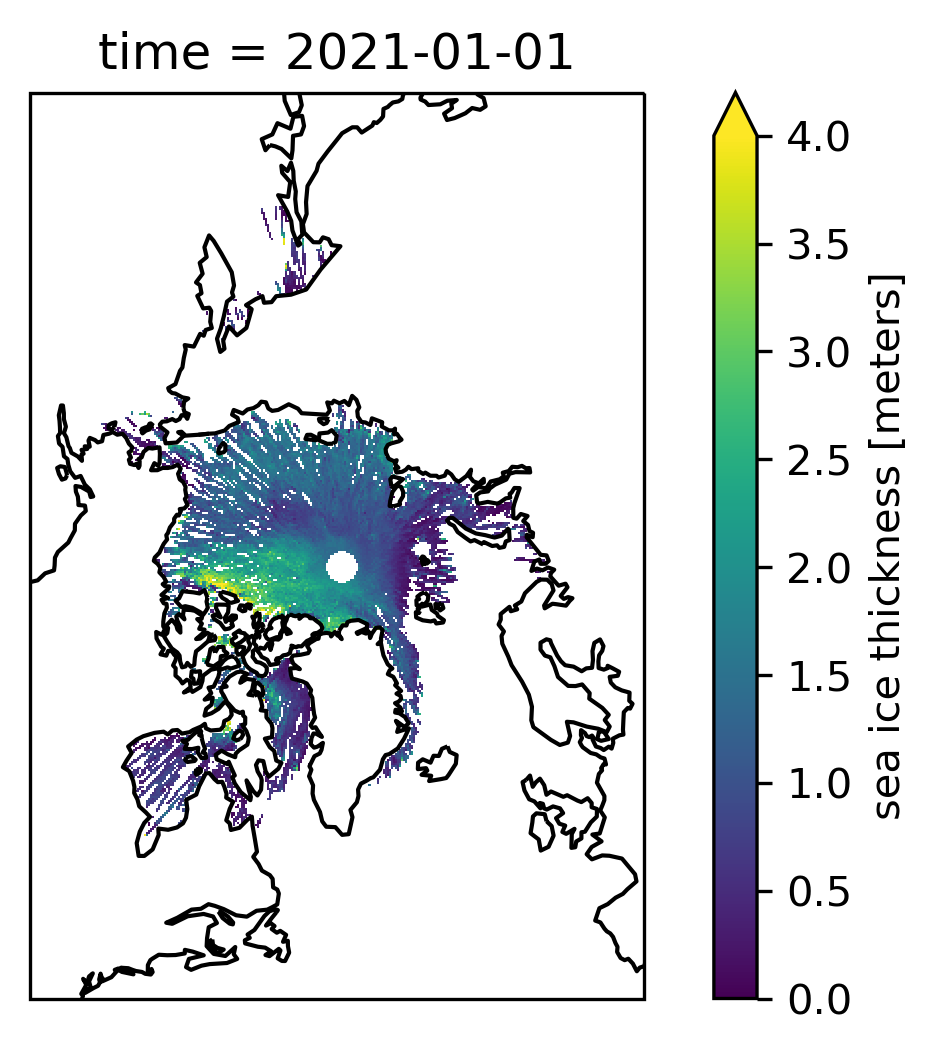

In [4]:
date = "Jan 2021"
var = "ice_thickness"
data_one_month = is2_ds[var].sel(time=date)
p = data_one_month.plot(x="longitude", y="latitude", # horizontal coordinates 
                        vmin=0, vmax=4, # min and max on the colorbar 
                        subplot_kws={'projection':ccrs.NorthPolarStereo(central_longitude=-45)}, # Set the projection 
                        transform=ccrs.PlateCarree())
p.axes.coastlines() # Add coastlines 
plt.show()

# Simple sea ice thickness maps
Using the function arguments `col` and `col_wrap`, we can modify the code for plotting one month of data to plot several months of data. Below, we'll plot sea ice thickness for Nov 2020 - Apr 2021.

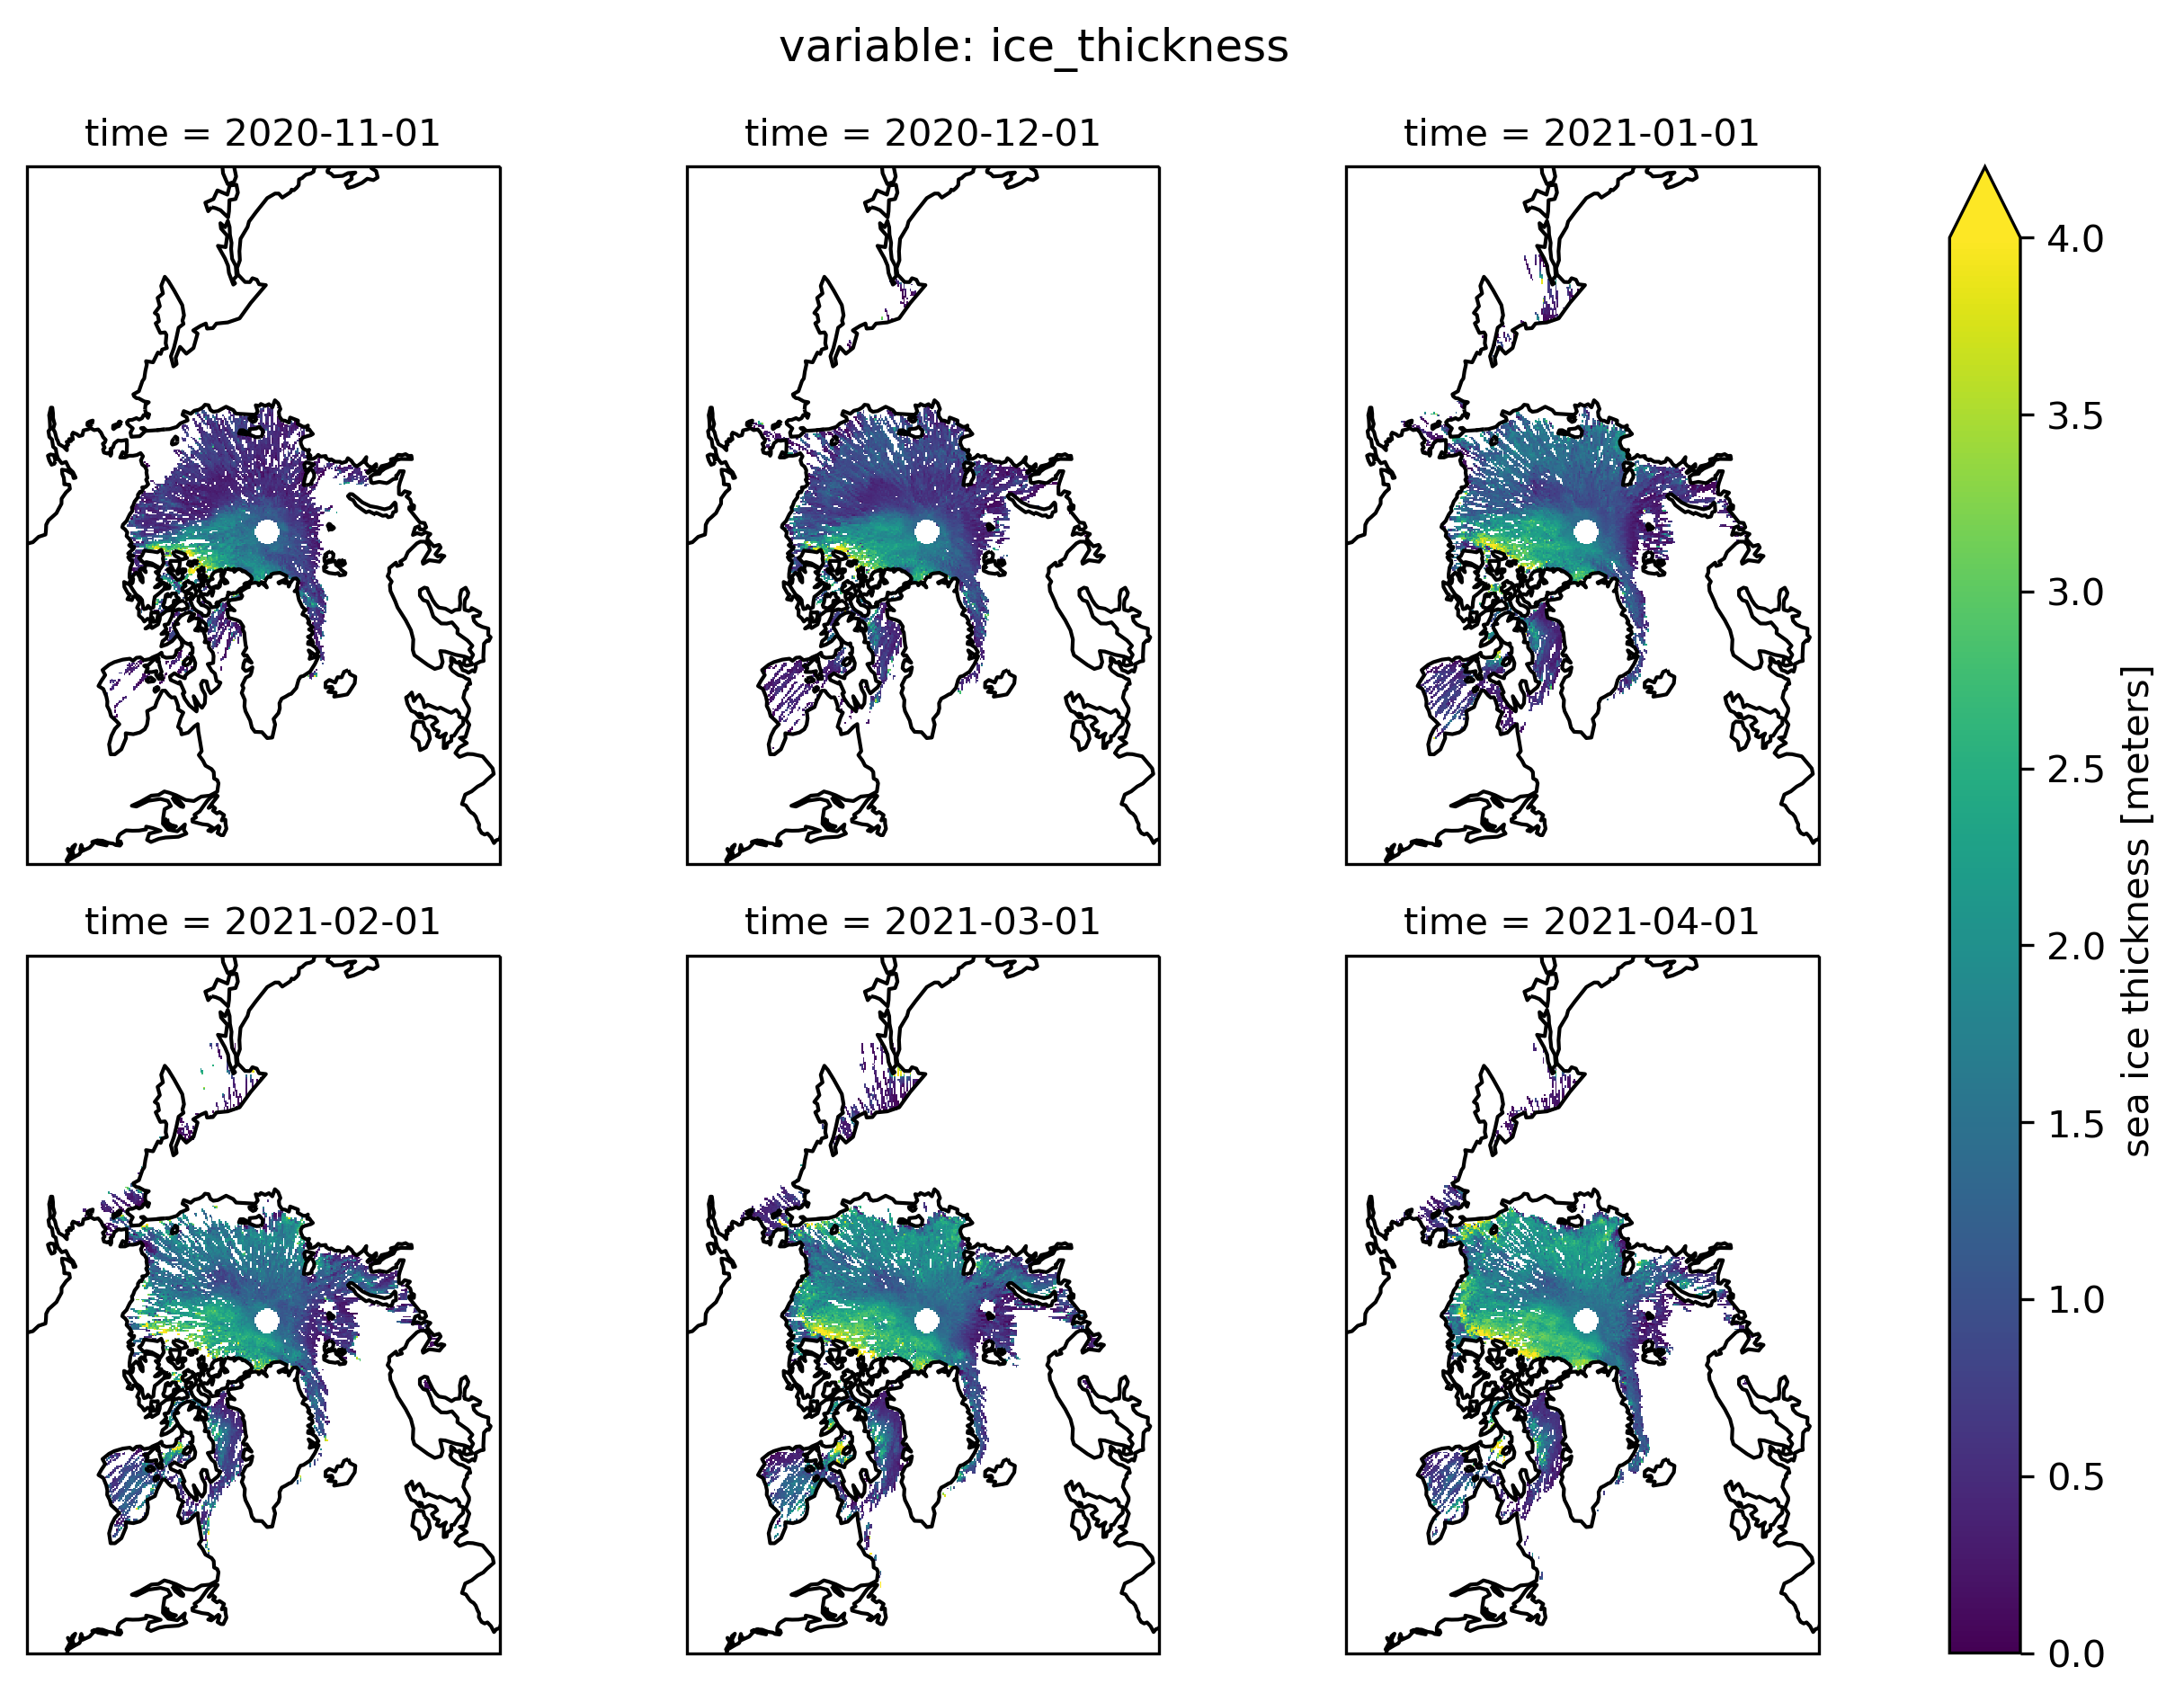

In [5]:
start_date = "Nov 2020"
end_date = "Apr 2021"
var = "ice_thickness" # Variable to use 
data_one_winter = is2_ds[var].sel(time=slice(start_date, end_date))
p = data_one_winter.plot(x="longitude", y="latitude", # Horizontal coordinates 
                         col="time", # Coordinate to use for facet grid 
                         col_wrap=3, # Number of columns to use 
                         vmin=0, vmax=4, # Min and max on the colorbar 
                         subplot_kws={'projection':ccrs.NorthPolarStereo(central_longitude=-45)}, # Set the projection 
                         transform=ccrs.PlateCarree())
for ax in p.axes.flat: # Add coastlines
    ax.coastlines()
plt.suptitle("variable: "+var, y=1.03) # Add a descriptive title
plt.show()

# Plot mean sea ice freeboard over time
Maybe we want to know how the mean has changed over time. Below, we'll compute the mean monthly sea ice freeboard for Sep 2020 - Apr 2021, and display the information in a simple lineplot. 

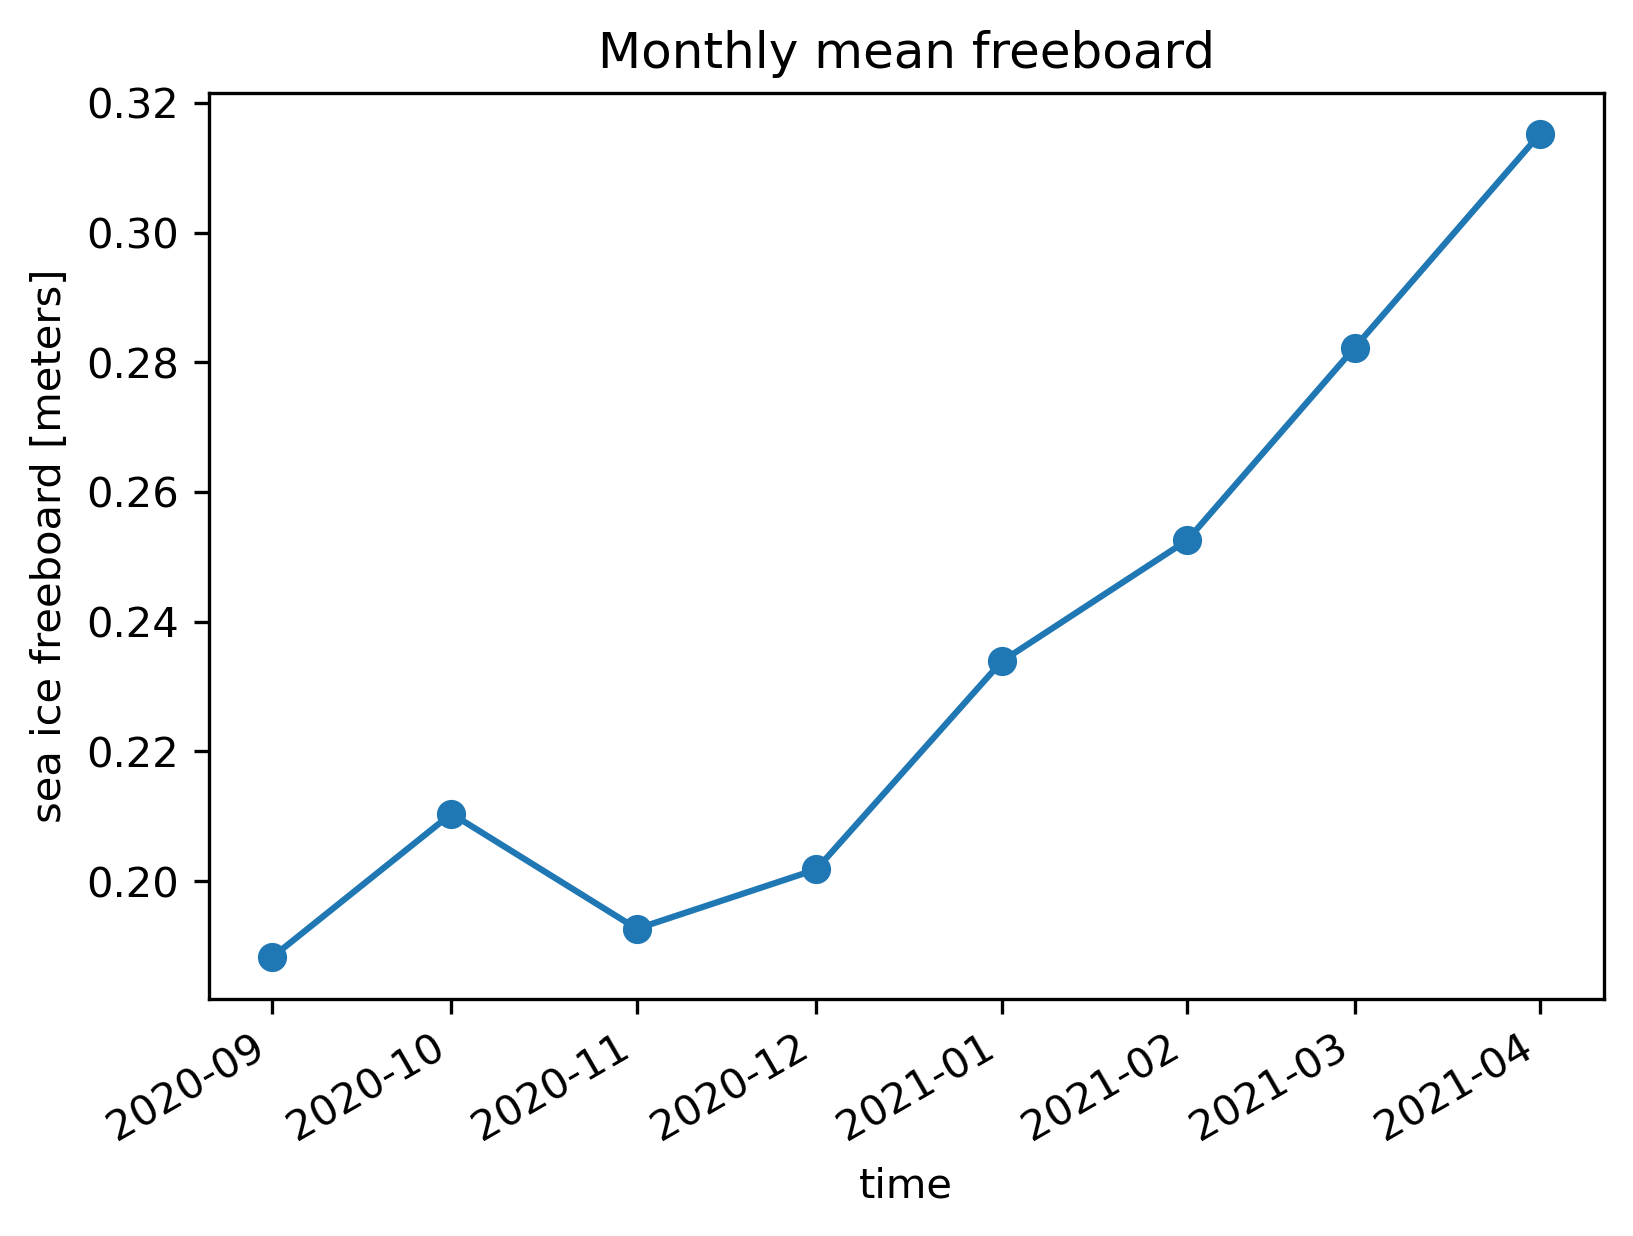

In [6]:
var = "freeboard" # Variable to use 
start_date = "Sep 2020"
end_date = "Apr 2021"
winter2020_21 = is2_ds.sel(time=slice(start_date, end_date)) # Grab data for Sep 2020 - Apr 2021
winter2020_21_mean = winter2020_21[var].mean(dim=["x","y"], # Dimensions over which to compute mean 
                                             keep_attrs=True) # Keep attributes from original dataset

lineplot = winter2020_21_mean.plot(marker='o') # Generate the lineplot 
plt.title("Monthly mean "+var) # Add a descriptive title 
plt.show()